# Install & Upgrade Library

In [ ]:
pip install gdown

In [ ]:
pip install tensorflow==2.15.0

In [ ]:
# pip install tensorflow==2.8 keras==2.8

In [ ]:
import tensorflow as tf
import keras

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.15.0
Keras version: 2.15.0


# Import Libary

In [ ]:
import numpy as np
import gdown
import os
import shutil
import seaborn as sns
import zipfile
import matplotlib.pyplot as plt
from PIL import Image
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import MobileNetV3Small,MobileNetV3Large

# Download dataset

In [ ]:
file_id = "19gbnCNEZNU8YkEH1UrIbYgRqEgaXaqq3"

# URL berbagi dari Google Drive
url = 'https://drive.google.com/uc?id=' + file_id

# Path untuk menyimpan file yang diunduh
output = 'dataset.zip'

# Mengunduh file
gdown.download(url, output, quiet=False)

# Mengekstrak file zip jika diperlukan
import zipfile

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('datasets/')

Downloading...
From (original): https://drive.google.com/uc?id=1UTYqfDzqiS4g9HKxusUFGLBSXb2RmVcK
From (redirected): https://drive.google.com/uc?id=1UTYqfDzqiS4g9HKxusUFGLBSXb2RmVcK&confirm=t&uuid=69883c89-96ca-45c6-9554-9c6fb3180b28
To: /content/dataset.zip
100%|██████████| 1.53G/1.53G [00:41<00:00, 36.8MB/s]


# Preprocessing

## Load and Clean Dataset

In [ ]:
def check_and_remove_invalid_images(root_dir):
    invalid_files = []
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            file_path = os.path.join(subdir, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Attempt to open and verify the image
            except Exception as e:
                print(f"Error processing image: {file_path} - {e}")
                invalid_files.append(file_path)
    # Remove invalid files
    for invalid_file in invalid_files:
        os.remove(invalid_file)
        print(f"Invalid image removed: {invalid_file}")

In [ ]:
def get_file_paths_and_labels(root_dir):
    # Check and remove invalid images before collecting file paths and labels
    check_and_remove_invalid_images(root_dir)

    file_paths = []
    labels = []
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            file_path = os.path.join(subdir, file)
            label = os.path.basename(subdir)
            file_paths.append(file_path)
            labels.append(label)
    return file_paths, labels

In [ ]:
# Direktori asal, train, dan validation
kaggle_prefix_dir = '/kaggle/working/'
colab_prefix_dir = '/content/'
prefix_dir = colab_prefix_dir

root_dir = prefix_dir + 'datasets/'
train_dir = prefix_dir + 'final-datasets/train'
val_dir = prefix_dir + 'final-datasets/valid'

# Membuat direktori train dan validation jika belum ada
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Mendapatkan semua jalur file dan labelnya
file_paths, labels = get_file_paths_and_labels(root_dir)

Error processing image: /content/datasets/bawang putih/bawang_putih_52.jpg - cannot identify image file '/content/datasets/bawang putih/bawang_putih_52.jpg'
Error processing image: /content/datasets/daun kemangi/daun_kemangi_221.jpg - cannot identify image file '/content/datasets/daun kemangi/daun_kemangi_221.jpg'
Error processing image: /content/datasets/daun kemangi/daun_kemangi_189.jpg - cannot identify image file '/content/datasets/daun kemangi/daun_kemangi_189.jpg'
Error processing image: /content/datasets/daun kemangi/daun_kemangi_196.jpg - cannot identify image file '/content/datasets/daun kemangi/daun_kemangi_196.jpg'
Invalid image removed: /content/datasets/bawang putih/bawang_putih_52.jpg
Invalid image removed: /content/datasets/daun kemangi/daun_kemangi_221.jpg
Invalid image removed: /content/datasets/daun kemangi/daun_kemangi_189.jpg
Invalid image removed: /content/datasets/daun kemangi/daun_kemangi_196.jpg


## Split Dataset

In [ ]:
def split_and_move_files(file_paths, labels, train_dir, val_dir, test_size=0.2):
    X_train, X_val, y_train, y_val = train_test_split(file_paths, labels, test_size=test_size, stratify=labels, random_state=234)

    for file_path, label in zip(X_train, y_train):
        label_dir = os.path.join(train_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(file_path, label_dir)

    for file_path, label in zip(X_val, y_val):
        label_dir = os.path.join(val_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(file_path, label_dir)

In [ ]:
# Membagi dan memindahkan file ke direktori train dan validation
split_and_move_files(
    file_paths,
    labels,
    train_dir,
    val_dir,
    test_size=0.1
    )

## Data Generator and Augmentation

In [ ]:
# ImageDataGenerator untuk training dan validation
train_datagen = ImageDataGenerator(
      rotation_range=50,          # Meningkatkan rotasi
      width_shift_range=0.3,      # Meningkatkan pergeseran lebar
      height_shift_range=0.3,     # Meningkatkan pergeseran tinggi
      shear_range=0.3,            # Meningkatkan geseran
      zoom_range=0.3,             # Meningkatkan zoom
      horizontal_flip=True,       # Membalik secara horizontal
      vertical_flip=True,         # Membalik secara vertikal
      brightness_range=[0.7,1.0], # Variasi kecerahan
      channel_shift_range=150.0,  # Pergeseran saluran
      fill_mode='nearest')
val_datagen = ImageDataGenerator()


# Membuat generator untuk training dan validation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 7294 images belonging to 31 classes.
Found 810 images belonging to 31 classes.


# Modeling

In [ ]:
model_name = 'mobilenetV3Large_v6'

In [ ]:
def plot_history(history):
    # Menyimpan history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    # Plotting loss
    plt.figure(figsize=(12, 5))

    # Plotting Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.tight_layout()
    plt.show()

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Memonitor akurasi validasi
    patience=5,              # Berhenti jika tidak ada perbaikan setelah 5 epoch
    verbose=1,               # Menampilkan informasi ketika berhenti
    restore_best_weights=True # Mengembalikan bobot terbaik
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=3e-7
)

In [ ]:
mobilenet_v3_large_model = MobileNetV3Large(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
mobilenet_v3_large_model.trainable= False

12683000/12683000 [==============================] - 0s 0us/step


# Fine Tuning

In [ ]:
mobilenet_v3_large_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(mobilenet_v3_large_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 80

# Freeze all the layers before the `fine_tune_at` layer
for layer in mobilenet_v3_large_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  263


In [ ]:
model = Sequential([
    mobilenet_v3_large_model,
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(31, activation='softmax')
])

optimizer = Adam(learning_rate=3e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
print("Input shape dari model:", model.input_shape)

Input shape dari model: (None, 224, 224, 3)


In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=40,
    batch_size = 8,
    verbose=2,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


228/228 - 200s - loss: 1.7595 - accuracy: 0.5059 - val_loss: 0.8443 - val_accuracy: 0.7309 - lr: 3.0000e-04 - 200s/epoch - 877ms/step
Epoch 2/40
228/228 - 163s - loss: 0.7119 - accuracy: 0.7835 - val_loss: 0.5575 - val_accuracy: 0.8481 - lr: 3.0000e-04 - 163s/epoch - 714ms/step
Epoch 3/40
228/228 - 162s - loss: 0.5190 - accuracy: 0.8427 - val_loss: 0.4399 - val_accuracy: 0.8679 - lr: 3.0000e-04 - 162s/epoch - 711ms/step
Epoch 4/40
228/228 - 162s - loss: 0.4478 - accuracy: 0.8618 - val_loss: 0.3592 - val_accuracy: 0.9000 - lr: 3.0000e-04 - 162s/epoch - 712ms/step
Epoch 5/40
228/228 - 163s - loss: 0.3971 - accuracy: 0.8726 - val_loss: 0.3872 - val_accuracy: 0.8988 - lr: 3.0000e-04 - 163s/epoch - 715ms/step
Epoch 6/40
228/228 - 161s - loss: 0.3304 - accuracy: 0.8939 - val_loss: 0.3941 - val_accuracy: 0.8901 - lr: 3.0000e-04 - 161s/epoch - 708ms/step
Epoch 7/40
228/228 - 159s - loss: 0.3054 - accuracy: 0.9046 - val_loss: 0.3607 - val_accuracy: 0.9160 - lr: 3.0000e-04 - 159s/epoch - 698ms/s

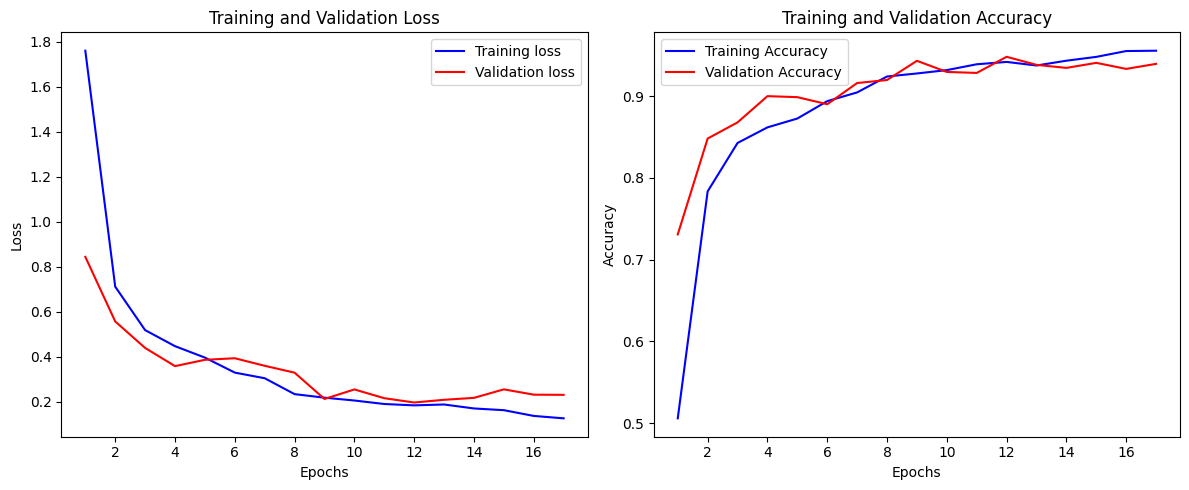

In [ ]:
plot_history(history)

# Save model

## Save class indices

In [ ]:
np.save('class_indices.npy', train_generator.class_indices)

## Save as h5 model

In [ ]:
model.save(f'{model_name}.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Save as JSON model

In [ ]:
# Instal TensorFlow.js converter
!pip install tensorflowjs

In [ ]:
!tensorflowjs_converter --input_format keras mobilenetV3Large_v1_combined.h5 tfjs_model

2024-06-13 07:15:01.376629: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 07:15:01.376715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 07:15:01.378692: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-13 07:15:03.714854: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 5, in <module>
    from tensorflowjs.converters.converter import pip_main
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/__init__.py", line

## Convert to Tflite

### Save as saved model

In [ ]:
model = load_model(f'{model_name}.h5')

In [ ]:
saved_model_dir = f'saved_model_{model_name}'
tf.saved_model.save(model, saved_model_dir)

In [ ]:
!pip install tensorflow=="2.13.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 39.8 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: keras
    F

In [ ]:
pip install tflite-support

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 22.2 MB/s eta 0:00:00


In [ ]:
class_indices = np.load('class_indices.npy', allow_pickle=True).item()

with open('class_labels.txt', 'w') as f:
    for class_name in class_indices:
        f.write(f"{class_name}\n")

In [ ]:
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
# converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Mengonversi model ke format TFLite
tflite_model = converter.convert()

# Save the model to a file
with open(f'{model_name}.tflite', 'wb') as f:
    f.write(tflite_model)

writer = image_classifier.MetadataWriter.create_for_inference(
    writer_utils.load_file(f'{model_name}.tflite'),
    input_norm_mean=[0],  # Mean value for normalization (0 means no normalization)
    input_norm_std=[1],   # Standard deviation for normalization (1 means no normalization)
    label_file_paths=['class_labels.txt']
)

writer_utils.save_file(writer.populate(), f'{model_name}_with_metadata.tflite')


# Make Prediction

In [ ]:
class_indices = np.load('class_indices.npy', allow_pickle=True).item()
class_labels = {v: k for k, v in class_indices.items()}
class_labels

{0: 'adas',
 1: 'andaliman',
 2: 'asam jawa',
 3: 'bawang bombai',
 4: 'bawang merah',
 5: 'bawang putih',
 6: 'biji ketumbar',
 7: 'bukan rempah',
 8: 'bunga lawang',
 9: 'cengkeh',
 10: 'daun jeruk',
 11: 'daun kemangi',
 12: 'daun ketumbar',
 13: 'daun salam',
 14: 'jahe',
 15: 'jinten',
 16: 'kapulaga',
 17: 'kayu manis',
 18: 'kayu secang',
 19: 'kemiri',
 20: 'kemukus',
 21: 'kencur',
 22: 'kluwek',
 23: 'kunyit',
 24: 'lada',
 25: 'lengkuas',
 26: 'pala',
 27: 'saffron',
 28: 'serai',
 29: 'vanili',
 30: 'wijen'}

In [ ]:
model = load_model(f'{model_name}.h5')

In [ ]:
from sklearn.metrics import classification_report

test_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    class_mode='categorical'
)


y_true = test_generator.classes

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Hitung metrik
report = classification_report(y_true, y_pred_classes)
print(report)

NameError: name 'val_datagen' is not defined

In [ ]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array


# Load class indices
class_indices = np.load('class_indices.npy', allow_pickle=True).item()
class_labels = {v: k for k, v in class_indices.items()}

# Upload files
uploaded = files.upload()

# Create test folder if it doesn't exist
if not os.path.exists('test'):
    os.makedirs('test')

for fn in uploaded.keys():
    # Move the uploaded file to the test folder
    os.rename(fn, os.path.join('test', fn))
    path = os.path.join('test', fn)

    # Predicting images
    img = load_img(path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    predictions = model.predict(x)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_label = class_labels[predicted_class_index]

    # Menampilkan hasil prediksi
    print(f'Gambar {fn} diprediksi sebagai kelas: {predicted_class_label} dengan probabilitas: {predictions[0][predicted_class_index]}')

Saving adas-1.jpg to adas-1.jpg
Saving bawang_bombay_1.jpg to bawang_bombay_1.jpg
Saving bawang_merah_1.jpg to bawang_merah_1.jpg
Saving bawang_merah_2.jpg to bawang_merah_2.jpg
Saving bawang-putih_1.jpg to bawang-putih_1.jpg
Saving bawang-putih_2.jpg to bawang-putih_2.jpg
Saving bawang-putih_3.jpg to bawang-putih_3.jpg
Saving bawang-putih_4.jpg to bawang-putih_4.jpg
Saving bawang-putih_5.jpg to bawang-putih_5.jpg
Saving bawang-putih_6.jpg to bawang-putih_6.jpg
Saving bawang-putih_7.jpg to bawang-putih_7.jpg
Saving bawang-putih_8.jpg to bawang-putih_8.jpg
Saving biji_ketumbar_1.jpg to biji_ketumbar_1.jpg
Saving bunga_lawang_1.jpg to bunga_lawang_1.jpg
Saving cengkeh_1.png to cengkeh_1.png
Saving daun_salam_1.jpg to daun_salam_1.jpg
Saving daun-jeruk_1.jpg to daun-jeruk_1.jpg
Saving daun-kemangi_1.jpg to daun-kemangi_1.jpg
Saving jahe_1.jpg to jahe_1.jpg
Saving kapulaga_1.jpg to kapulaga_1.jpg
Saving kayu_manis_1.png to kayu_manis_1.png
Saving kayu_manis_2.png to kayu_manis_2.png
Saving

# Model Interpretability




In [ ]:
from tflite_support import metadata

# Path to the TFLite model file
model_path = 'mobilenet_v3_with_metadata_v2.tflite'

# Directory to extract the associated files
extract_dir = 'tflite_metadata'

# Create the directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Load the TFLite model
displayer = metadata.MetadataDisplayer.with_model_file(model_path)

# Get the list of associated files
associated_files = displayer.get_packed_associated_file_list()

# Extract the associated files
for file_name in associated_files:
    content = displayer.get_associated_file_buffer(file_name)
    file_path = os.path.join(extract_dir, file_name)
    with open(file_path, 'wb') as f:
        f.write(content)

# Path to the extracted class_labels.txt file
labels_path = os.path.join(extract_dir, 'class_labels.txt')

# Read and print the content of class_labels.txt
with open(labels_path, 'r') as f:
  labels = labels.strip()
  label_list = labels.split('\n')
  for i in range(len(label_list)):
    print(f'{i} : {label_list[i]}')

0 : adas
1 : andaliman
2 : asam jawa
3 : bawang bombai
4 : bawang merah
5 : bawang putih
6 : biji ketumbar
7 : bukan rempah
8 : bunga lawang
9 : cengkeh
10 : daun jeruk
11 : daun kemangi
12 : daun ketumbar
13 : daun salam
14 : jahe
15 : jinten
16 : kapulaga
17 : kayu manis
18 : kayu secang
19 : kemiri
20 : kemukus
21 : kencur
22 : kluwek
23 : kunyit
24 : lada
25 : lengkuas
26 : pala
27 : saffron
28 : serai
29 : vanili
30 : wijen


## Test Image

In [ ]:
image_path = '/content/final-datasets/train/bawang putih/bawang-putih_78.jpg'

# read the image
img = cv2.imread(image_path)

# format it to be the RGB colorspace
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# resize to 300x300 and normalize pixel values to be in the range [0, 1]
img = cv2.resize(img, (224, 224)) / 255.0

image = img

class_index = 26
num_classes = 31

expected_output = tf.one_hot(class_index, num_classes)

# batch1, labels_batch1 = next(test_generator)
# y_true = np.argmax(labels_batch1, axis=1)

# image = batch1[0]
# expected_output = labels_batch1[0]

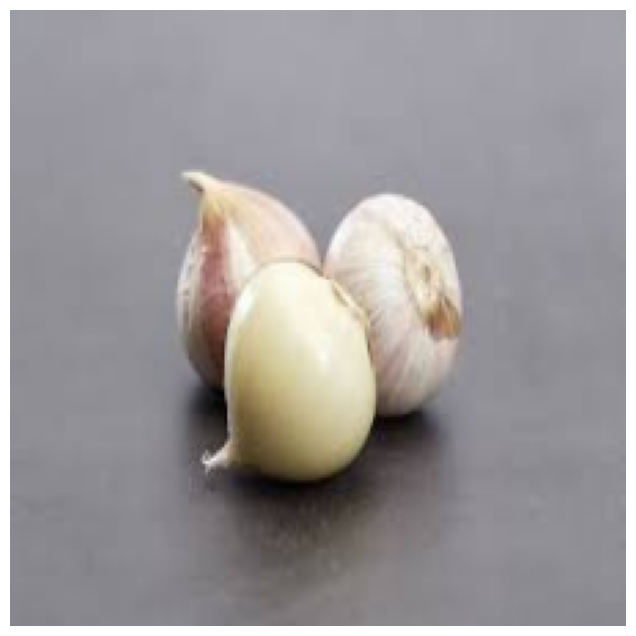

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
expected_output =  np.expand_dims(expected_output, axis=0)
image = np.expand_dims(image, axis=0)

with tf.GradientTape() as tape:
  # cast image to float
  inputs = tf.cast(image, tf.float32)

  # watch the input pixels
  tape.watch(inputs)

  # generate the predictions
  predictions = model(inputs)

  # get the loss
  loss = tf.keras.losses.categorical_crossentropy(
      expected_output, predictions
  )

# get the gradient with respect to the inputs
gradients = tape.gradient(loss, inputs)

In [ ]:
# reduce the RGB image to grayscale
grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

# normalize the pixel values to be in range [0, 255].
# the max value in the grayscale tensor will be pushed to 255.
# the min value will be push to 0.
normalized_tensor = tf.cast(
    255
    * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
    / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8
)

# remove the channel dimension to make the tensor a 2D tensor
normalized_tensor = tf.squeeze(normalized_tensor)

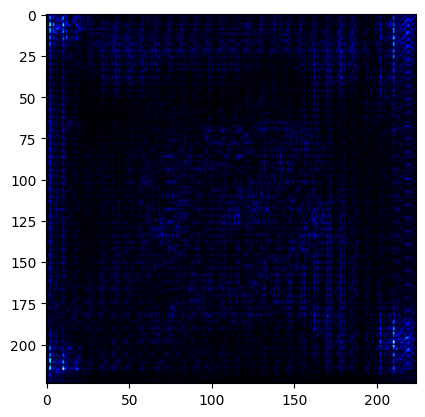

In [ ]:
gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
plt.imshow(gradient_color)

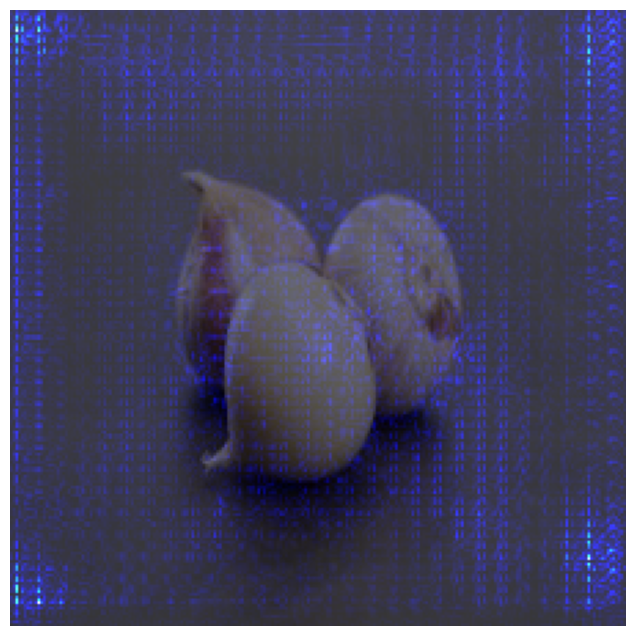

In [ ]:
gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
gradient_color = gradient_color / 255.0
super_imposed = cv2.addWeighted(img, 0.4, gradient_color, 0.9, 0.0)

plt.figure(figsize=(8, 8))
plt.imshow(super_imposed)
plt.axis("off")
plt.show()